# Imports

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from rkstiff.grids import construct_x_kx_rfft
from rkstiff.etd34 import ETD34
%matplotlib inline

# Construct grids

In [40]:
# uniform grid spacing, field assumed to be real-valued -> construct_x_kx_rfft
N = 512
a, b = -150, 150
x,kx = construct_x_kx_rfft(N,a,b)

# Linear and nonlinear functions for spectral kdV equation

In [41]:
L = 1j*kx**3

def NLfunc(uf):
    u = np.fft.irfft(uf)
    ux = np.fft.irfft(1j*kx*uf)
    return -6*np.fft.rfft(u*ux)

# Initial values set to a combination of kdV solitons

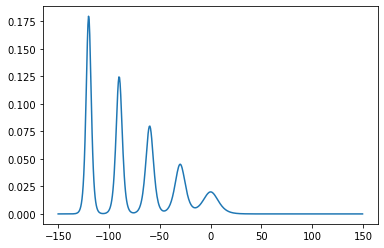

In [42]:
A0 = np.array([0.6, 0.5, 0.4, 0.3, 0.2]).reshape(1,5)
x0 = np.array([-120, -90, -60, -30, 0]).reshape(1,5)
u0 = 0.5*A0**2/(np.cosh(A0*(x.reshape(N,1)-x0)/2)**2)
u0 = np.sum(u0,axis=1)
u0FFT = np.fft.rfft(u0)

plt.plot(x,u0)

# Initialize ETD34 solver

In [43]:
solver = ETD34(linop=L,NLfunc=NLfunc)
solver.epsilon = 1e-4

# Propagate step by step

tf =  600.39802928823


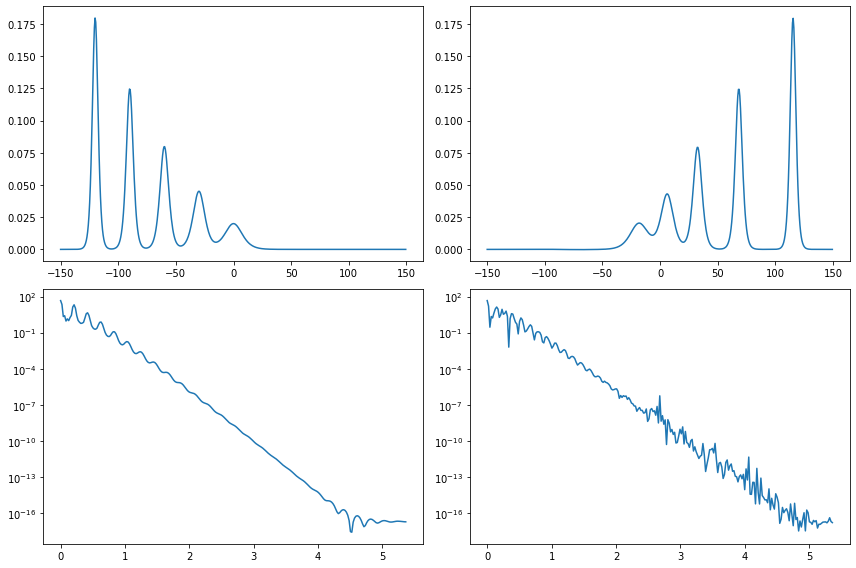

In [44]:
maxsteps = 10000
uFFT = u0FFT.copy()
t, h = 0, 0.1
stepnum = 0
while t < 600 and stepnum < maxsteps:
    uFFT,h,h_suggest = solver.step(uFFT,h)
    t += h
#    use suggested step (or not for a constant step size scheme)
    h = h_suggest 
    stepnum += 1
    
print('tf = ',t)
uf = np.fft.irfft(uFFT)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2,sharey = ax1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4,sharey = ax3)
ax1.plot(x,u0)
ax2.plot(x,uf)
ax3.plot(kx,np.abs(u0FFT)**2)
ax4.plot(kx,np.abs(uFFT)**2)
ax3.set_yscale('log')
ax4.set_yscale('log')
fig.tight_layout()

# Propagate from time t0 to tf

In [45]:
# store_data -> propagated field stored in ETD34.u at times ETD34.t 
# store_freq -> propagated field values stored on every store_freq step (default is every step)
uFFT = solver.evolve(u0FFT,t0=0,tf=600,store_data=True,store_freq=25)

In [46]:
print(np.linalg.norm(u0FFT))
print(np.linalg.norm(uFFT))
print((np.linalg.norm(u0FFT)-np.linalg.norm(uFFT))/np.linalg.norm(uFFT))

12.318000488292395
12.310444392903108
0.0006137955014558898


In [47]:
def waterfall(x,t,u,**kwargs):
    if 'figsize' in kwargs:
        fig = plt.figure(figsize=kwargs['figsize'])
    else:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.w_xaxis.set_pane_color((0,0,0,0))
    ax.w_yaxis.set_pane_color((0,0,0,0))
    ax.w_zaxis.set_pane_color((0,0,0,0))
    for i,snapshot in enumerate(u):
        ax.plot(x,t[i]*np.ones_like(x),snapshot,color='black')
    plt.xlim([x[0],x[-1]])
    plt.ylim([t[0],t[-1]])
    plt.tight_layout()
    return ax

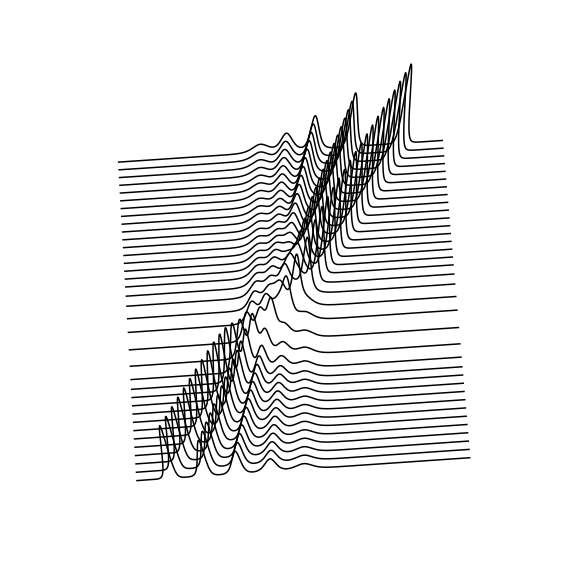

In [48]:
U = []
for u in solver.u:
    U.append(np.fft.irfft(u))
U = np.array(U)
t = np.array(solver.t)
ax = waterfall(x,t,U,figsize=(8,8))
ax.grid(False)
ax.axis(False)
ax.view_init(75,-94)